In [22]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

In [23]:
# Inicializamos valores

w = 2.6617e-6

G = 6.67e-11
mt = 5.9736e24
rt = 6.3781e6 #rad tierra
ml = 0.07349e24
rl = 1.7374e6 #rad luna
d = 3.844e8 # tierra Luna

delta = ((G*mt)/d**3)
mu = ml/mt

In [24]:
def rp(r,phi,t):
    f = np.sqrt(1+r**2-2*r*np.cos(phi-w*t))
    return f


def rpunto(pr):
    f = pr
    return f
def phipunto(r,pphi):
    f = pphi/r**2
    return f
def Prpunto(r,phi,pphi,t):
    f = pphi**2/r**3 - delta*(1/r**2 + mu/(rp(r,phi,t))**3*(r-np.cos(phi-w*t)))
    return f
def Pphipunto(r,phi,pphi,t):
    f = - delta*mu*r*np.sin(phi-w*t)/(rp(r,phi,t))**3
    return f


def Getpr(v0,theta0,phi0):
    f = v0*np.cos(theta0-phi0)
    return f

def Getpphi(r0,v0,theta0,phi0):
    f = r0*v0*np.sin(theta0-phi0)
    return f

theta0 = 25/180.*np.pi
phi0 = 0.
r0 = rt
v0 = 11100
pr0 = Getpr(v0/d,theta0,phi0)
pphi0 = Getpphi(r0/d, v0/d,theta0,phi0)

In [25]:
def GetRungeKutta4(t1,tf,h):
    
    N = int((tf - t1)/ h) + 1
    
    t = np.linspace(t1,tf,N)
    
    r = np.zeros([N])
    phi = np.zeros([N])
    pr = np.zeros([N])
    pphi = np.zeros([N])
    
    r[0] = r0/d
    phi[0] = phi0
    pr[0] = pr0
    pphi[0] = pphi0
    
    
    K1 = np.zeros(4)
    K2 = np.zeros(4)
    K3 = np.zeros(4)
    K4 = np.zeros(4)

    
    for i in tqdm(range(1, N)):

        K1[0] = h*rpunto(pr[i-1])
        K1[1] = h*phipunto(r[i-1],pphi[i-1])
        K1[2] = h*Prpunto(r[i-1],phi[i-1],pphi[i-1],t[i-1])
        K1[3] = h*Pphipunto(r[i-1],phi[i-1],pphi[i-1],t[i-1])
        
        K2[0] = h*rpunto(pr[i-1] + 0.5*K1[2])
        K2[1] = h*phipunto(r[i-1] + 0.5*K1[0],pphi[i-1] + 0.5*K1[3])
        K2[2] = h*Prpunto(r[i-1] + 0.5*K1[0],phi[i-1] + 0.5*K1[1],pphi[i-1] + 0.5*K1[3],t[i-1] + 0.5)
        K2[3] = h*Pphipunto(r[i-1] + 0.5*K1[0],phi[i-1] + 0.5*K1[1],pphi[i-1] + 0.5*K1[3],t[i-1] + 0.5)
        
        K3[0] = h*rpunto(pr[i-1] + 0.5*K2[2])
        K3[1] = h*phipunto(r[i-1] + 0.5*K2[0],pphi[i-1] + 0.5*K2[3])
        K3[2] = h*Prpunto(r[i-1] + 0.5*K2[0],phi[i-1] + 0.5*K2[1],pphi[i-1] + 0.5*K2[3],t[i-1] + 0.5)
        K3[3] = h*Pphipunto(r[i-1] + 0.5*K2[0],phi[i-1] + 0.5*K2[1],pphi[i-1] + 0.5*K2[3],t[i-1] + 0.5)
        
        K4[0] = h*rpunto(pr[i-1]+K3[2])
        K4[1] = h*phipunto(r[i-1]+K3[0],pphi[i-1]+K3[3])
        K4[2] = h*Prpunto(r[i-1]+K3[0],phi[i-1]+K3[1],pphi[i-1]+K3[3],t[i-1]+h)
        K4[3] = h*Pphipunto(r[i-1]+K3[0],phi[i-1]+K3[1],pphi[i-1]+K3[3],t[i-1]+h)
        
        r[i] = r[i-1]+(K1[0]+2*K2[0]+2*K3[0]+K4[0])/6
        phi[i] = phi[i-1]+(K1[1]+2*K2[1]+2*K3[1]+K4[1])/6
        pr[i] = pr[i-1]+(K1[2]+2*K2[2]+2*K3[2]+K4[2])/6
        pphi[i] = pphi[i-1]+(K1[3]+2*K2[3]+2*K3[3]+K4[3])/6
        

    return t,phi,r
    
t, phi, r = GetRungeKutta4(0, 6e5, 8)

100%|██████████| 75000/75000 [00:04<00:00, 15696.06it/s]


In [26]:
new_t = []
new_r = []
new_phi = []

for i in range(len(t)):
    if i%1000 == 0:
        new_t.append(t[i])
        new_r.append(r[i])
        new_phi.append(phi[i])
        
t = np.array(new_t)
r = np.array(new_r)
phi = np.array(new_phi)

In [27]:
xLuna, yLuna = np.cos(w*t), np.sin(w*t) #Luna
x, y = r*np.cos(phi), r*np.sin(phi)     #Nave

<IPython.core.display.Javascript object>


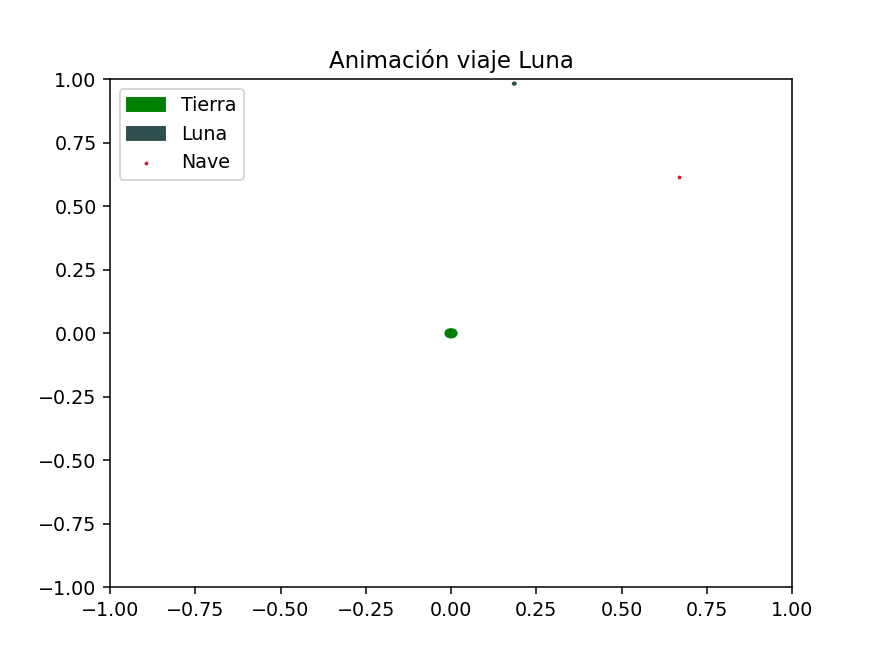

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def init():

    ax.set_title("Animación viaje Luna")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
def animate(i):
    plot = ax.clear()
    init()
    
    Tierra = plt.Circle((0,0), rt/d, color = 'g', label = 'Tierra')
    Luna = plt.Circle((xLuna[i], yLuna[i]), rl/d, color='darkslategrey', label = 'Luna')
    plot = ax.add_patch(Tierra)
    plot = ax.add_patch(Luna)
    
    plot = ax.scatter(x[i], y[i], color = 'crimson', s=1, label = 'Nave')
    
    
    plot = plt.legend(loc = 2)
    
    return plot

frames = len(t)

Animation = anim.FuncAnimation(fig, animate, frames, init_func=init)